In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle
#import statsmodels.api as sm
import seaborn as sns
from collections import Counter
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
import scipy.stats as stats
from opioidrx_voe.utils import *


In [2]:
pop = pd.read_csv('../voe_outputs/opioids/controlsLessThan3Opioids/' \
                  'binary_exposure/binary_outcome/controlVarOUD/populations/' \
                  'voe_2014_2017_5yearfollowup_5OpioidsEnrollment_45NCDageExclusion_1.csv')

/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
pop.shape

(396202, 17)

In [4]:
pop.head()

,Unnamed: 0,MRN,AGE,DOB,RACE,SEX,YOB,age,label,ncd,sickle,hiv,aud,tobacco,sud,opioid_count,MAT
0,0,1001419,83.0,1939-09-12,WHITE,Male,1939,78,0,0,0,0,0,0,0,0.0,0
1,1,1001868,74.0,1948-10-22,WHITE,Male,1948,69,0,0,0,0,0,0,0,0.0,0
2,2,1003267,80.0,1942-04-20,WHITE,Female,1942,75,0,0,0,0,0,0,0,0.0,0
3,3,1003565,68.0,1954-05-14,AFRICAN-AMERICAN,Female,1954,63,0,0,0,0,0,0,0,0.0,0
4,4,1004882,76.0,1946-01-23,WHITE,Male,1946,71,0,1,0,0,0,0,0,0.0,0


In [3]:
oprx_pop = pop[pop.label==1]

opioid_mrns = oprx_pop.MRN
control_mrns = pop[pop.label==0].MRN

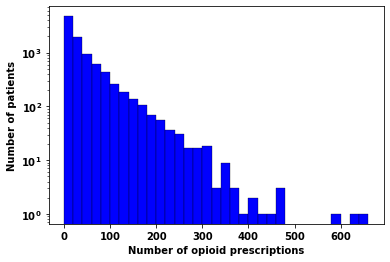

In [4]:
#histogram of opioid prescriptions in OPRx cohort
c,b,_ = plt.hist(oprx_pop.opioid_count, log=True,
                 bins=np.arange(0,680,20), color='blue', edgecolor='black', linewidth=0.3)
plt.xlabel('Number of opioid prescriptions')
plt.ylabel('Number of patients')
plt.savefig('../figures/histogram_OPRx_cohortEnroll5OPRx_enroll2014-2016_NCDAgeExclusion_45.png', dpi=300)

In [7]:
c[2]/oprx_pop.shape[0], c[1]/oprx_pop.shape[0], c[0]/oprx_pop.shape[0]

(0.09651307596513076, 0.20029057700290576, 0.4940846824408468)

In [5]:
def fisher(cases_data, controls_data, factor):
    import scipy.stats as stats
    import sys
    
    ORs = []
    pvalues = []
    cases_with_list = []
    controls_with_list = []
    cases_without_list = []
    controls_without_list = []
    
    #overlapping factors (e.g., dx, rx), Ns of groups
    allfactors = list(set(cases_data[factor]).union(set(controls_data[factor])))
    num_cases = len(set(cases_data.MRN))
    num_controls = len(set(controls_data.MRN))
    
    #counts of each factor
    cases_rx_counts = cases_data.groupby(factor).groups
    controls_rx_counts = controls_data.groupby(factor).groups
    
    n=0
    for i in allfactors:
        sys.stdout.write('%i out of %i.\r' % (n+1, len(allfactors)))
        sys.stdout.flush()
        
        #number of patients with factor
        if i in list(cases_rx_counts.keys()):
            cases_with = len(set(cases_data.iloc[cases_rx_counts[i]].MRN))#cases_data.count(i)
        else: cases_with = 0
        
        if i in list(controls_rx_counts.keys()):
            controls_with = len(set(controls_data.iloc[controls_rx_counts[i]].MRN))#controls_data.count(i)
        else: controls_with = 0
        
        cases_without = num_cases - cases_with
        controls_without = num_controls - controls_with
        
        cases_with_list.append(cases_with)
        controls_with_list.append(controls_with)
        cases_without_list.append(cases_without)
        controls_without_list.append(controls_without)
        
        #if any zeros in 2x2 table, add 1 to all cells
        if 0 in [cases_with, cases_without, controls_with, controls_without]:
            oddsratio, pvalue = stats.fisher_exact([[cases_with+1, cases_without+1],
                                                    [controls_with+1, controls_without+1]])
        else:
            oddsratio, pvalue = stats.fisher_exact([[cases_with, cases_without], [controls_with, controls_without]])
        
        ORs.append(oddsratio)
        #bonferroni correction
        pvalues.append(pvalue*len(allfactors))
        
        n+=1
    
    fisher_data = pd.DataFrame()
    fisher_data[factor] = allfactors
    fisher_data['Cases_with'] = cases_with_list
    fisher_data['Cases_w/o'] = cases_without_list
    fisher_data['Cases_percent'] = fisher_data['Cases_with']/num_cases
    fisher_data['Controls_with'] = controls_with_list
    fisher_data['Controls_w/o'] = controls_without_list
    fisher_data['Controls_percent'] = fisher_data['Controls_with']/num_controls
    fisher_data['opi-con_percent'] = fisher_data['Cases_percent'] - fisher_data['Controls_percent']
    fisher_data['Odds_ratio'] = ORs
    fisher_data['p-value (Bonferroni-corrected)'] = pvalues
    
    fisher_data = fisher_data.sort_values(by=['Odds_ratio', 'p-value (Bonferroni-corrected)'],
                                         ascending=[False,True]).reset_index(drop=True)
    
    return fisher_data

## Meds

In [6]:
med = pd.read_parquet('../tidy_data/Medications.parquet')


In [7]:
def get_drugs(df):
    drugs = []

    for entry in df['MEDICATION_GENERIC_NAME']:
        idx = entry.find(' ')
        drugs.append(entry[:idx])
        
    df['drug'] = drugs
    return df

In [8]:
#Compare medications of controls vs. OPRx, for all meds in patients' entire record

opi_cohort_allmeds = med[med.MRN.isin(opioid_mrns)]
opi_cohort_allmeds.loc[:,'MEDICATION_START_DATE'] = pd.to_datetime(opi_cohort_allmeds.loc[:,'MEDICATION_START_DATE'])
opi_cohort_allmeds = opi_cohort_allmeds[#(opi_cohort_allmeds.date>=begin) & 
                                        (opi_cohort_allmeds.MEDICATION_START_DATE < '01-01-2017')]
opi_cohort_allmeds.reset_index(drop=True, inplace=True)
opi_cohort_allmeds = get_drugs(opi_cohort_allmeds)

con_cohort_allmeds = med[med.MRN.isin(control_mrns)]
con_cohort_allmeds.loc[:,'MEDICATION_START_DATE'] = pd.to_datetime(con_cohort_allmeds['MEDICATION_START_DATE'].copy())
con_cohort_allmeds = con_cohort_allmeds[#(con_cohort_allmeds.date>=begin) & 
                                        (con_cohort_allmeds.MEDICATION_START_DATE < '01-01-2017')]
con_cohort_allmeds.reset_index(drop=True, inplace=True)
con_cohort_allmeds = get_drugs(con_cohort_allmeds)

/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [9]:
rx_compare = fisher(opi_cohort_allmeds, con_cohort_allmeds, 'drug')

In [10]:
rx_compare.to_csv('../tidy_data/fisher_prescriptions_compare_cohortEnroll5OPRx_enroll2014-2016_NCDAgeExclusion_45.csv')
# rx_compare = pd.read_csv('../tidy_data/fisher_prescriptions_compare_cohortEnroll5OPRx_enroll2014-2016_NCDAgeExclusion_45.csv')

In [12]:
rx_compare.head()

,drug,Cases_with,Cases_w/o,Cases_percent,Controls_with,Controls_w/o,Controls_percent,opi-con_percent,Odds_ratio,p-value (Bonferroni-corrected),PHARMACEUTICAL_CLASS
0,OXYMORPHONE,223,9413,0.023142,9,20581,0.000437,0.022705,54.175230,7.918384e-96,OPIOID ANALGESICS
1,PROPOXYPHENE,37,9599,0.003840,2,20588,0.000097,0.003743,39.678925,2.199810e-14,OPIOID ANALGESICS
2,HYDROCODONE-GUAIFENESIN,11,9625,0.001142,0,20590,0.000000,0.001142,25.669229,1.541588e-03,OPIOID ANTITUSSIVE-EXPECTORANT COMBINATION
3,TAPENTADOL,226,9410,0.023454,23,20567,0.001117,0.022337,21.476422,4.951059e-83,OPIOID ANALGESICS
4,BUPRENORPHINE-NALOXONE,10,9626,0.001038,1,20589,0.000049,0.000989,21.388947,1.292287e-02,"OPIOID WITHDRAWAL THERAPY AGENTS, OPIOID-TYPE"


In [11]:
print(rx_compare.shape)
merge_med = pd.concat([opi_cohort_allmeds, con_cohort_allmeds]).loc[:,['drug','PHARMACEUTICAL_CLASS']].drop_duplicates()

# 12 extra rows after merge (see next cell)
rx_compare = rx_compare.merge(merge_med, on="drug")
print(rx_compare.shape)

# some drugs are derived from different MEDICATION_GENERIC_NAME with different PHARMACEUTICAL_CLASS
# solution: drop_duplicates on all numerical columns
rx_compare.drop_duplicates(subset=rx_compare.columns[1:-1], inplace=True)
print(rx_compare.shape)

(153, 10)
(165, 11)
(115, 11)


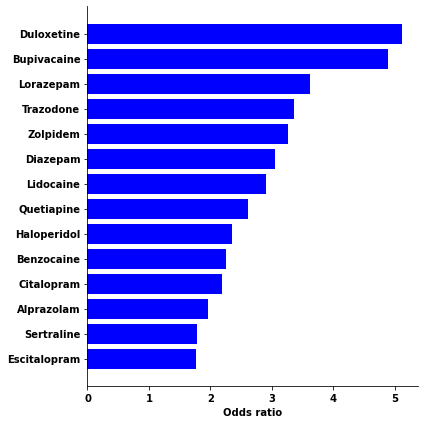

In [13]:
fig, ax = plt.subplots(figsize=(6,6))

variable = 'Odds_ratio'
rx_compare_sig = rx_compare[rx_compare['p-value (Bonferroni-corrected)']<0.05].sort_values(variable, ascending=False)
rx_compare_sig = rx_compare_sig[~rx_compare_sig.PHARMACEUTICAL_CLASS.str.contains('OPIOID')]
rx_compare_sig = rx_compare_sig[(rx_compare_sig.Cases_percent>0.05) | 
                               ((rx_compare_sig.Controls_percent>0.05))]

#if there are any drugs overrepresented in the controls, show the top and bottom 10
if min(rx_compare_sig[variable])<1:
    data = pd.concat([rx_compare_sig[:10], rx_compare_sig[-10:]])
#if not, just show the top 20
else:
    data = rx_compare_sig[:20]

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.barh(np.arange(data.shape[0]), data[variable],  align='center', color='blue')
ax.set_yticks(np.arange(data.shape[0]), labels=data.drug.str.title())
# ax.set_yticks(())

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Odds ratio')
plt.tight_layout()
plt.savefig('../figures/rx_fisherTest_oddsratio_bargraph_OPRx_cohortEnroll5OPRx_enroll2014-2016_NCDAgeExclusion_45.png', dpi=300)

## Diagnoses

In [14]:
dx = pd.read_parquet('../tidy_data/Diagnosis.parquet')


In [15]:
dx.head()

,MRN,ENC_EPIC_CSN_ID,AGE_AT_ENCOUNTER,ENCOUNTER_DATE,DIAGNOSIS_DATE,DIAGNOSIS_TYPE,DIAGNOSIS,CODE,CODE_TYPE
0,3062956,120775621,91,2016-04-14 09:30:00,2016-04-14,Hospital Problem,"Vascular dementia, unspecified severity, witho...",F01.50,ICD-10-CM
2,E568340,120036715,53,2016-03-25 00:00:00,2016-03-25,Encounter Diagnosis,"Nicotine dependence, unspecified, uncomplicated",F17.200,ICD-10-CM
3,1815591,100048049741,53,2019-03-26 00:00:00,2019-03-26,Encounter Diagnosis,"Depression, unspecified",F32.A,ICD-10-CM
4,3219657,100047681176,70,2019-04-18 00:00:00,2019-04-18,Encounter Diagnosis,Human immunodeficiency virus (HIV) disease,B20,ICD-10-CM
5,1188409,100049583743,85,2019-05-09 00:00:00,2019-05-09,Encounter Diagnosis,"Major depressive disorder, single episode, mod...",F32.1,ICD-10-CM


In [16]:
opi_cohort_dx = dx[dx.MRN.isin(opioid_mrns)]
opi_cohort_dx['DIAGNOSIS_DATE'] = pd.to_datetime(opi_cohort_dx['DIAGNOSIS_DATE'])
opi_cohort_dx = opi_cohort_dx[#(opi_cohort_icd9.date>=begin) & 
                                    (opi_cohort_dx.DIAGNOSIS_DATE<'01-01-2017')]
opi_cohort_dx.reset_index(drop=True, inplace=True)


con_cohort_dx = dx[dx.MRN.isin(control_mrns)]
con_cohort_dx['DIAGNOSIS_DATE'] = pd.to_datetime(con_cohort_dx['DIAGNOSIS_DATE'])
con_cohort_dx = con_cohort_dx[#(con_cohort_icd9.date>=begin) & 
                                    (con_cohort_dx.DIAGNOSIS_DATE<'01-01-2017')]
con_cohort_dx.reset_index(drop=True, inplace=True)

/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [17]:
dx_compare = fisher(opi_cohort_dx, con_cohort_dx, 'DIAGNOSIS')

In [18]:
dx_compare.to_csv('../tidy_data/fisher_diagnoses_compare_cohortEnroll5OPRx_enroll2014-2016_NCDAgeExclusion_45.csv')
# dx_compare = pd.read_csv('../tidy_data/fisher_diagnoses_compare_cohortEnroll5OPRx_enroll2014-2016_NCDAgeExclusion_45.csv')

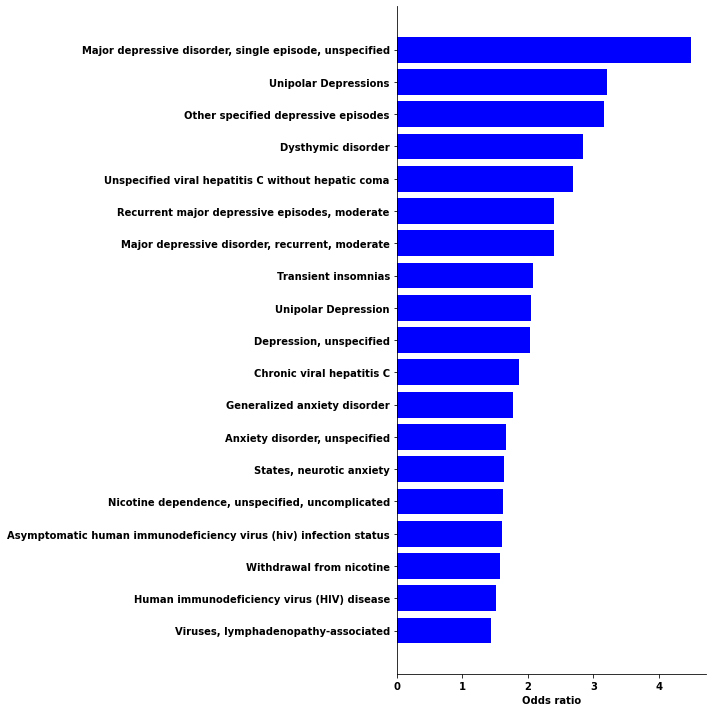

In [20]:
fig, ax = plt.subplots(figsize=(10,10))

variable = 'Odds_ratio'
dx_compare_sig = dx_compare[dx_compare['p-value (Bonferroni-corrected)']<0.05].sort_values(variable, ascending=False)
dx_compare_sig = dx_compare_sig[~dx_compare_sig.DIAGNOSIS.str.contains('|'.join(['Opioid','opioid']))]
dx_compare_sig = dx_compare_sig[(dx_compare_sig.Cases_percent>0.05) | 
                               ((dx_compare_sig.Controls_percent>0.05))]

#if there are any drugs overrepresented in the controls, show the top and bottom 10
if min(rx_compare_sig[variable])<1:
    data = pd.concat([dx_compare_sig[:10], dx_compare_sig[-10:]])
#if not, just show the top 20
else:
    data = dx_compare_sig[:20]
    
    
# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.barh(np.arange(data.shape[0]), data[variable],  align='center', color='blue')

# yticks = data.LABEL.tolist()
# yticks[4] = 'Alcohol dependence, continuous'
# yticks[5] = 'Alcohol dependence, unspecified'
# yticks[6] = 'Drug abuse, unspecified'
# yticks[10] = 'Open wound of finger(s), no complications'
# yticks[11] = 'Abnormal results of cardiovascular function study'
# yticks[12] = 'Accidents from cutting/piercing instruments'
# yticks[14] = 'Benign hypertensive heart disease w/o heart failure'
# yticks[16] = 'Routine general medical examination'
# yticks[17] = 'Benign neoplasm of connective tissue of upper limb'
# yticks[19] = 'Malignant hypertensive heart disease w/o heart failure'

ax.set_yticks(np.arange(data.shape[0]), labels=data.DIAGNOSIS)#yticks)
# ax.set_yticks(())

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Odds ratio')
plt.tight_layout()
plt.savefig('../figures/dx_fisherTest_oddsratio_OPRx_cohortEnroll5OPRx_enroll2014-2016_NCDAgeExclusion_45.png', dpi=300)